In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from itertools import combinations
import random

In [71]:
stress10_df = pd.read_csv("cleaned_data/stress10-cleaned.csv")
stress25_df = pd.read_csv("cleaned_data/stress25-cleaned.csv")
stress50_df = pd.read_csv("cleaned_data/stress50-cleaned.csv")

nt_stress10_df = pd.read_csv("cleaned_data/nt_stress10-cleaned.csv")
nt_stress25_df = pd.read_csv("cleaned_data/nt_stress25-cleaned.csv")
nt_stress50_df = pd.read_csv("cleaned_data/nt_stress50-cleaned.csv")

expert_df = pd.read_csv("cleaned_data/stress_expert-cleaned.csv")

ex_stress10_df = expert_df[['deltas10', 'accuracy10', 'confidence10', 'answers10', 'time10', 'drawings10']].copy()
ex_stress25_df = expert_df[['deltas25', 'accuracy25', 'confidence25', 'answers25', 'time25', 'drawings25']].copy()
ex_stress50_df = expert_df[['deltas50', 'accuracy50', 'confidence50', 'answers50', 'time50', 'drawings50']].copy()

ex_stress10_df.columns = ['deltas', 'accuracy', 'confidence', 'answers', 'time', 'drawings']
ex_stress25_df.columns = ['deltas', 'accuracy', 'confidence', 'answers', 'time', 'drawings']
ex_stress50_df.columns = ['deltas', 'accuracy', 'confidence', 'answers', 'time', 'drawings']

preference10_df = pd.read_csv("cleaned_data/preference10-cleaned.csv")
preference25_df = pd.read_csv("cleaned_data/preference25-cleaned.csv")
preference50_df = pd.read_csv("cleaned_data/preference50-cleaned.csv")


def parse_column_to_list(df, column_name):
    return df[column_name].apply(eval)


for df in [stress10_df, stress25_df, stress50_df, nt_stress10_df, nt_stress25_df, nt_stress50_df, ex_stress10_df, ex_stress25_df, ex_stress50_df]:
    df['deltas'] = parse_column_to_list(df, 'deltas')
    df['accuracy'] = parse_column_to_list(df, 'accuracy')
    df['confidence'] = parse_column_to_list(df, 'confidence')
    df['answers'] = parse_column_to_list(df, 'answers')

    df['average_accuracy'] = df['accuracy'].apply(lambda x: sum(x) / len(x))

for df in [preference10_df, preference25_df, preference50_df]:
    df['deltas'] = parse_column_to_list(df, 'deltas')
    df['accuracy'] = parse_column_to_list(df, 'accuracy')
    df['answers'] = parse_column_to_list(df, 'answers')

    df['average_accuracy'] = df['accuracy'].apply(lambda x: sum(x) / len(x))

# 10 nodes: untrained vs preference

Correlation: 0.08247158476021914


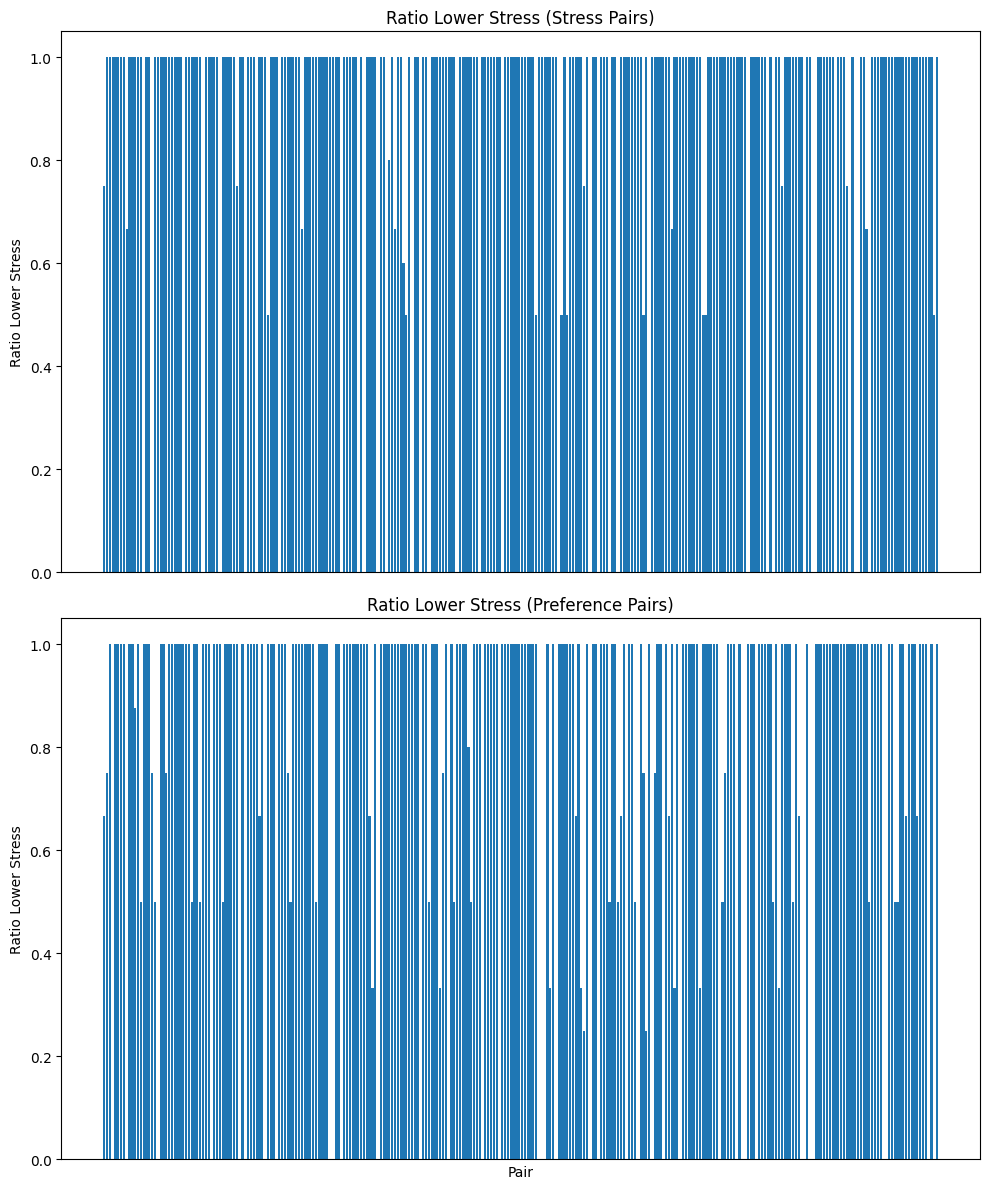

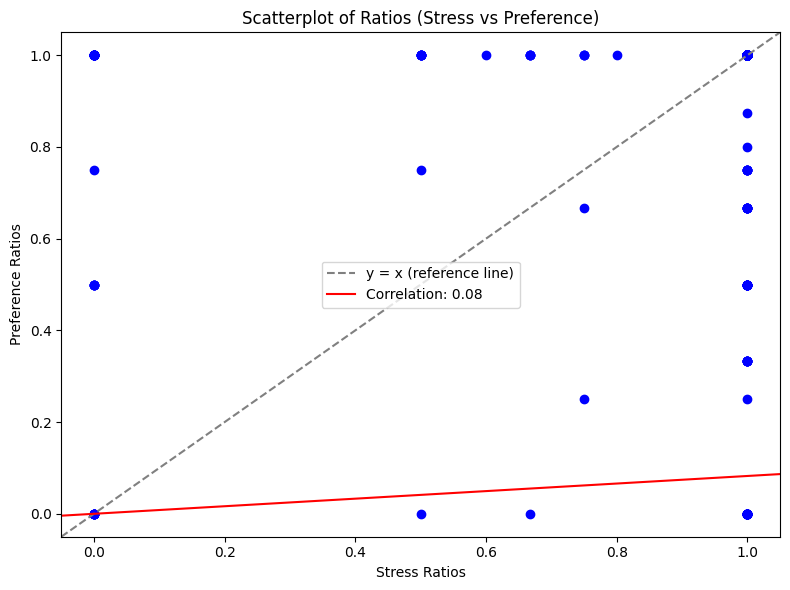

In [72]:
# Define the grid structure for the keys
g_values = [f"g{i}" for i in range(1, 6)]  # g1 to g5
l_values = [40, 45, 50, 55, 60, 65, 70, 75, 80]  # l40 to l80
ta_values = ["a", "b", "c"]  # a to c

# Generate all keys in the required format
keys = [f"{g}_l{l}_{ta}" for l in l_values for g in g_values for ta in ta_values]

# Generate all possible pairs (order-independent using combinations)
all_possible_pairs = list(combinations(keys, 2))

# Initialize the dictionary with all possible pairs as keys (frozensets for order-independence)
stress_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}
preference_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}


for index, row in nt_stress10_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        stress_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            stress_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 3:
            stress_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            stress_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            stress_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1

for index, row in preference10_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        preference_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            preference_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 2:
            preference_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            preference_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            preference_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1


# Remove entries from where 'total' < 1
stress_pair_dict_10 = {k: v for k, v in stress_pair_dict_10.items() if v['total'] >= 1}
preference_pair_dict_10 = {k: v for k, v in preference_pair_dict_10.items() if v['total'] >= 1}


# # Find the intersection of keys from both dictionaries
common_keys = set(stress_pair_dict_10.keys()).intersection(preference_pair_dict_10.keys())

# # Create the filtered dictionaries with only the common keys
stress_pair_dict_10_filtered = {k: stress_pair_dict_10[k] for k in common_keys}
preference_pair_dict_10_filtered = {k: preference_pair_dict_10[k] for k in common_keys}

for key, value in stress_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Add 'ratio_lower_stress' to the filtered preference dictionary
for key, value in preference_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Ensure common_keys is a sequence by converting it to a list
# random_keys = random.sample(list(common_keys), 15)


# stress_pair_dict_10_filtered2 = {k: stress_pair_dict_10[k] for k in random_keys}
# preference_pair_dict_10_filtered2 = {k: preference_pair_dict_10[k] for k in random_keys}

keys_stress = [' & '.join(key) for key in stress_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_stress = [value['ratio_lower_stress'] for value in stress_pair_dict_10_filtered.values()]

keys_preference = [' & '.join(key) for key in preference_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_preference = [value['ratio_lower_stress'] for value in preference_pair_dict_10_filtered.values()]

correlation = np.corrcoef(ratios_stress, ratios_preference)[0, 1]

print(f"Correlation: {correlation}")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)  # Two rows, one column

# First bar chart
axes[0].bar(keys_stress, ratios_stress)
axes[0].set_title('Ratio Lower Stress (Stress Pairs)')
axes[0].set_ylabel('Ratio Lower Stress')
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Second bar chart
axes[1].bar(keys_preference, ratios_preference)
axes[1].set_title('Ratio Lower Stress (Preference Pairs)')
axes[1].set_xlabel('Pair')
axes[1].set_ylabel('Ratio Lower Stress')
axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Adjust layout
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ratios_stress, ratios_preference, color='blue')#, label=f'Correlation: {correlation:.2f}')
plt.title('Scatterplot of Ratios (Stress vs Preference)')
plt.xlabel('Stress Ratios')
plt.ylabel('Preference Ratios')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='y = x (reference line)')
plt.axline((0, 0), slope=correlation, color='red', linestyle='-', label=f'Correlation: {correlation:.2f}')
plt.legend()
plt.tight_layout()
plt.show()



# 10 Nodes: trained vs preference

Correlation: 0.11859287428334647


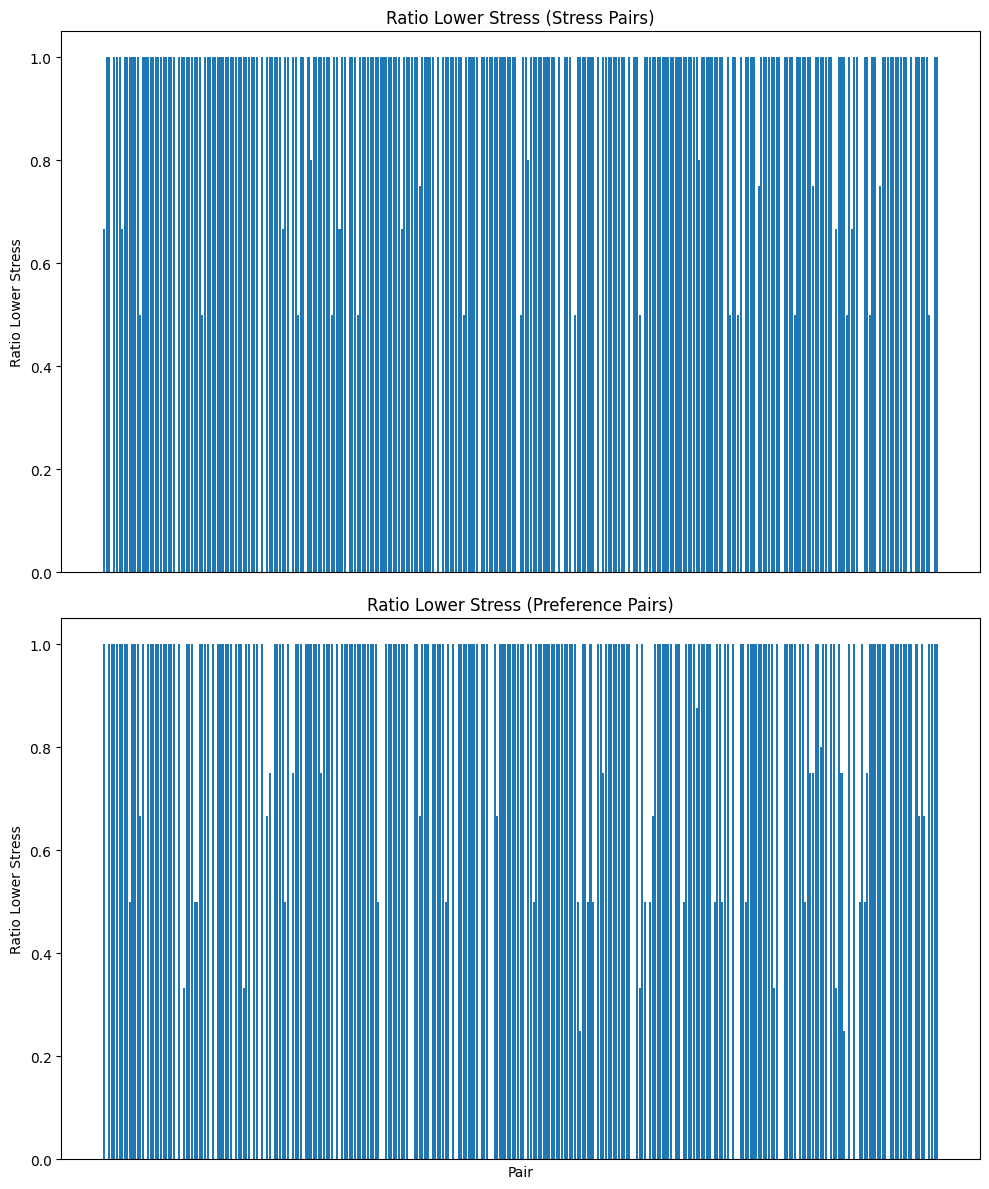

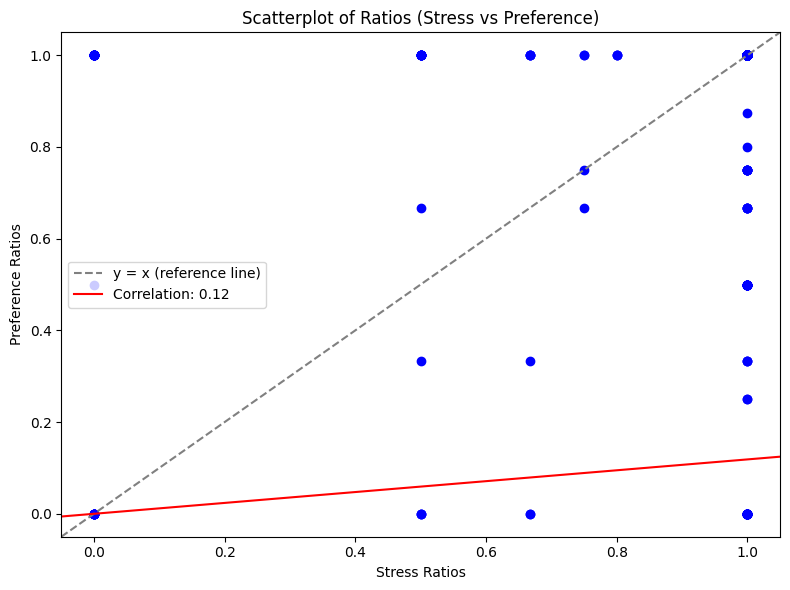

In [73]:
# Define the grid structure for the keys
g_values = [f"g{i}" for i in range(1, 6)]  # g1 to g5
l_values = [40, 45, 50, 55, 60, 65, 70, 75, 80]  # l40 to l80
ta_values = ["a", "b", "c"]  # a to c

# Generate all keys in the required format
keys = [f"{g}_l{l}_{ta}" for l in l_values for g in g_values for ta in ta_values]

# Generate all possible pairs (order-independent using combinations)
all_possible_pairs = list(combinations(keys, 2))

# Initialize the dictionary with all possible pairs as keys (frozensets for order-independence)
stress_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}
preference_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}


for index, row in stress10_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        stress_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            stress_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 3:
            stress_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            stress_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            stress_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1

for index, row in preference10_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        preference_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            preference_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 2:
            preference_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            preference_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            preference_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1


# Remove entries from where 'total' < 1
stress_pair_dict_10 = {k: v for k, v in stress_pair_dict_10.items() if v['total'] >= 1}
preference_pair_dict_10 = {k: v for k, v in preference_pair_dict_10.items() if v['total'] >= 1}


# # Find the intersection of keys from both dictionaries
common_keys = set(stress_pair_dict_10.keys()).intersection(preference_pair_dict_10.keys())

# # Create the filtered dictionaries with only the common keys
stress_pair_dict_10_filtered = {k: stress_pair_dict_10[k] for k in common_keys}
preference_pair_dict_10_filtered = {k: preference_pair_dict_10[k] for k in common_keys}

for key, value in stress_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Add 'ratio_lower_stress' to the filtered preference dictionary
for key, value in preference_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Ensure common_keys is a sequence by converting it to a list
# random_keys = random.sample(list(common_keys), 15)


# stress_pair_dict_10_filtered2 = {k: stress_pair_dict_10[k] for k in random_keys}
# preference_pair_dict_10_filtered2 = {k: preference_pair_dict_10[k] for k in random_keys}

keys_stress = [' & '.join(key) for key in stress_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_stress = [value['ratio_lower_stress'] for value in stress_pair_dict_10_filtered.values()]

keys_preference = [' & '.join(key) for key in preference_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_preference = [value['ratio_lower_stress'] for value in preference_pair_dict_10_filtered.values()]

correlation = np.corrcoef(ratios_stress, ratios_preference)[0, 1]

print(f"Correlation: {correlation}")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)  # Two rows, one column

# First bar chart
axes[0].bar(keys_stress, ratios_stress)
axes[0].set_title('Ratio Lower Stress (Stress Pairs)')
axes[0].set_ylabel('Ratio Lower Stress')
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Second bar chart
axes[1].bar(keys_preference, ratios_preference)
axes[1].set_title('Ratio Lower Stress (Preference Pairs)')
axes[1].set_xlabel('Pair')
axes[1].set_ylabel('Ratio Lower Stress')
axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Adjust layout
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ratios_stress, ratios_preference, color='blue')#, label=f'Correlation: {correlation:.2f}')
plt.title('Scatterplot of Ratios (Stress vs Preference)')
plt.xlabel('Stress Ratios')
plt.ylabel('Preference Ratios')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='y = x (reference line)')
plt.axline((0, 0), slope=correlation, color='red', linestyle='-', label=f'Correlation: {correlation:.2f}')
plt.legend()
plt.tight_layout()
plt.show()



# 10 nodes: expert vs preference

Correlation: 0.22526551086850885


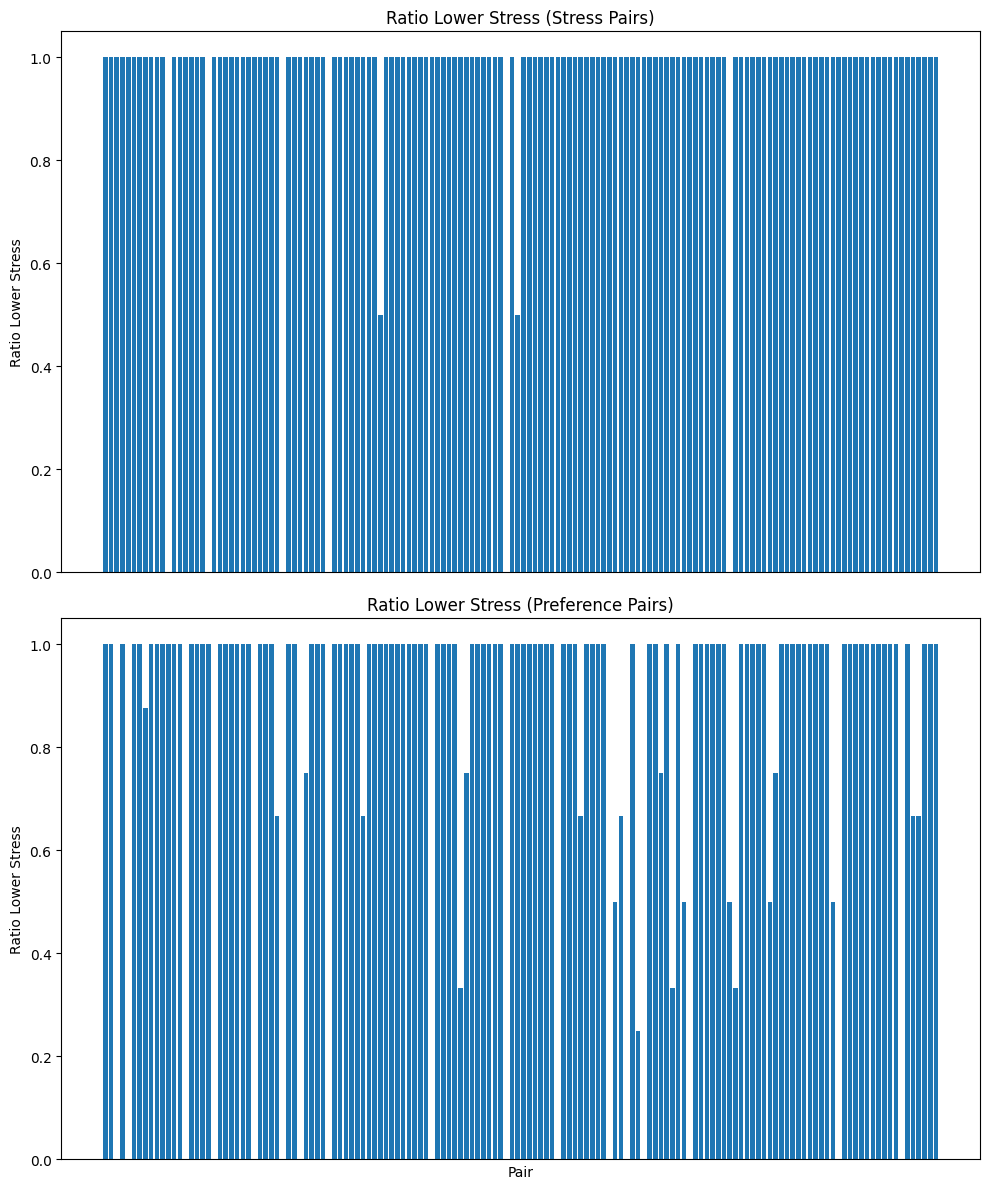

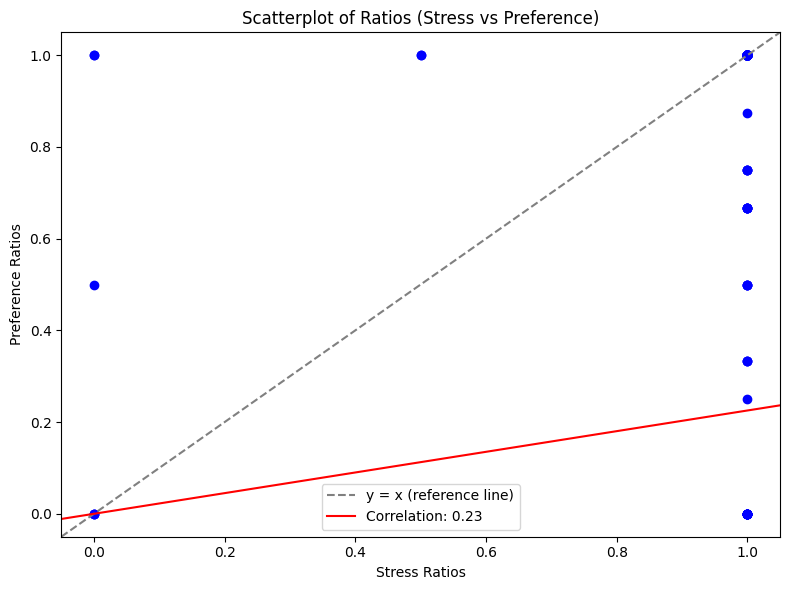

In [74]:
# Define the grid structure for the keys
g_values = [f"g{i}" for i in range(1, 6)]  # g1 to g5
l_values = [40, 45, 50, 55, 60, 65, 70, 75, 80]  # l40 to l80
ta_values = ["a", "b", "c"]  # a to c

# Generate all keys in the required format
keys = [f"{g}_l{l}_{ta}" for l in l_values for g in g_values for ta in ta_values]

# Generate all possible pairs (order-independent using combinations)
all_possible_pairs = list(combinations(keys, 2))

# Initialize the dictionary with all possible pairs as keys (frozensets for order-independence)
stress_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}
preference_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}


for index, row in ex_stress10_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        stress_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            stress_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 3:
            stress_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            stress_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            stress_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1

for index, row in preference10_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        preference_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            preference_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 2:
            preference_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            preference_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            preference_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1


# Remove entries from where 'total' < 1
stress_pair_dict_10 = {k: v for k, v in stress_pair_dict_10.items() if v['total'] >= 1}
preference_pair_dict_10 = {k: v for k, v in preference_pair_dict_10.items() if v['total'] >= 1}


# # Find the intersection of keys from both dictionaries
common_keys = set(stress_pair_dict_10.keys()).intersection(preference_pair_dict_10.keys())

# # Create the filtered dictionaries with only the common keys
stress_pair_dict_10_filtered = {k: stress_pair_dict_10[k] for k in common_keys}
preference_pair_dict_10_filtered = {k: preference_pair_dict_10[k] for k in common_keys}

for key, value in stress_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Add 'ratio_lower_stress' to the filtered preference dictionary
for key, value in preference_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Ensure common_keys is a sequence by converting it to a list
# random_keys = random.sample(list(common_keys), 15)


# stress_pair_dict_10_filtered2 = {k: stress_pair_dict_10[k] for k in random_keys}
# preference_pair_dict_10_filtered2 = {k: preference_pair_dict_10[k] for k in random_keys}

keys_stress = [' & '.join(key) for key in stress_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_stress = [value['ratio_lower_stress'] for value in stress_pair_dict_10_filtered.values()]

keys_preference = [' & '.join(key) for key in preference_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_preference = [value['ratio_lower_stress'] for value in preference_pair_dict_10_filtered.values()]

correlation = np.corrcoef(ratios_stress, ratios_preference)[0, 1]

print(f"Correlation: {correlation}")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)  # Two rows, one column

# First bar chart
axes[0].bar(keys_stress, ratios_stress)
axes[0].set_title('Ratio Lower Stress (Stress Pairs)')
axes[0].set_ylabel('Ratio Lower Stress')
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Second bar chart
axes[1].bar(keys_preference, ratios_preference)
axes[1].set_title('Ratio Lower Stress (Preference Pairs)')
axes[1].set_xlabel('Pair')
axes[1].set_ylabel('Ratio Lower Stress')
axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Adjust layout
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ratios_stress, ratios_preference, color='blue')#, label=f'Correlation: {correlation:.2f}')
plt.title('Scatterplot of Ratios (Stress vs Preference)')
plt.xlabel('Stress Ratios')
plt.ylabel('Preference Ratios')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='y = x (reference line)')
plt.axline((0, 0), slope=correlation, color='red', linestyle='-', label=f'Correlation: {correlation:.2f}')
plt.legend()
plt.tight_layout()
plt.show()



# All graph size: untrained vs preference

Correlation: 0.11853436527983528


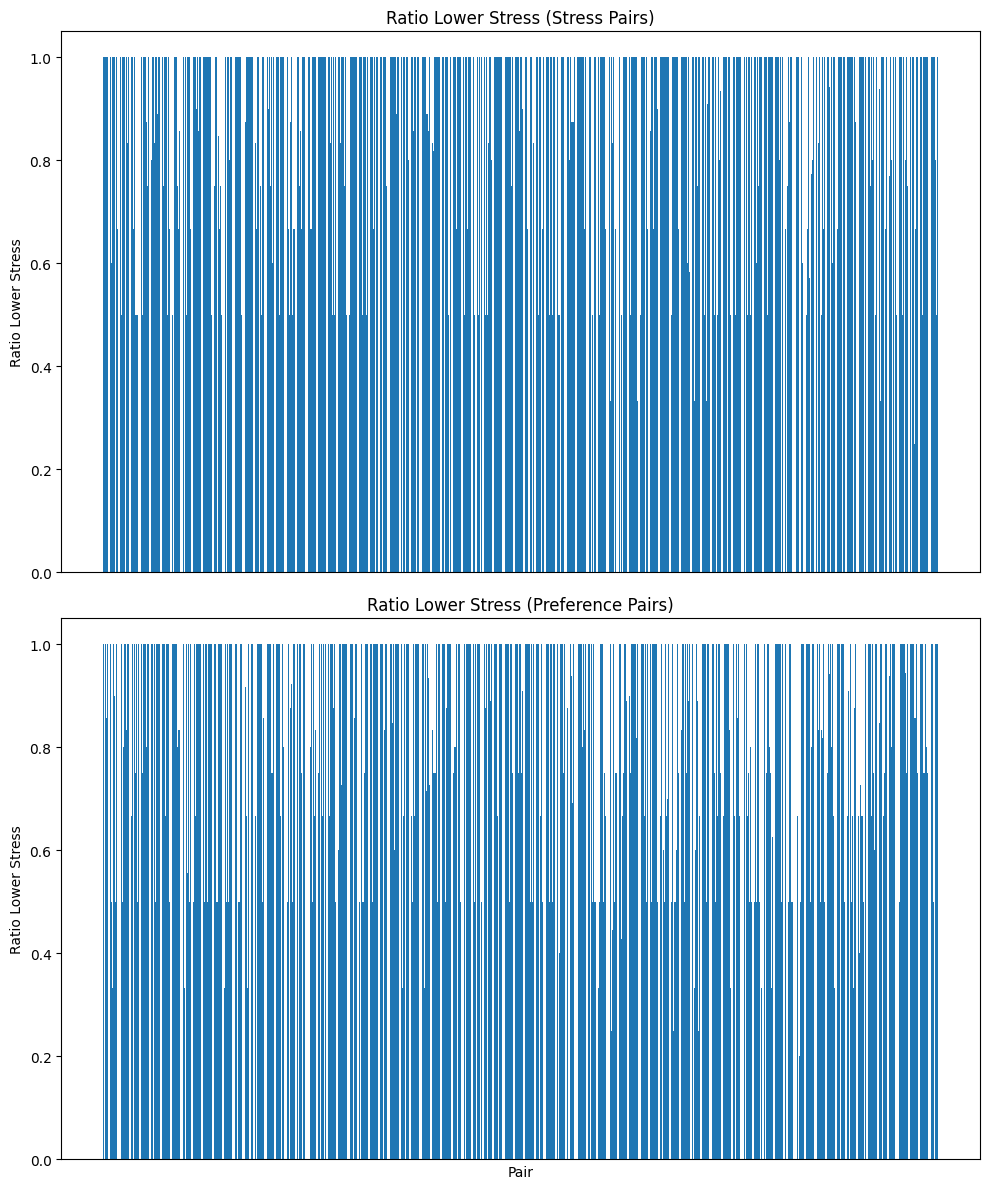

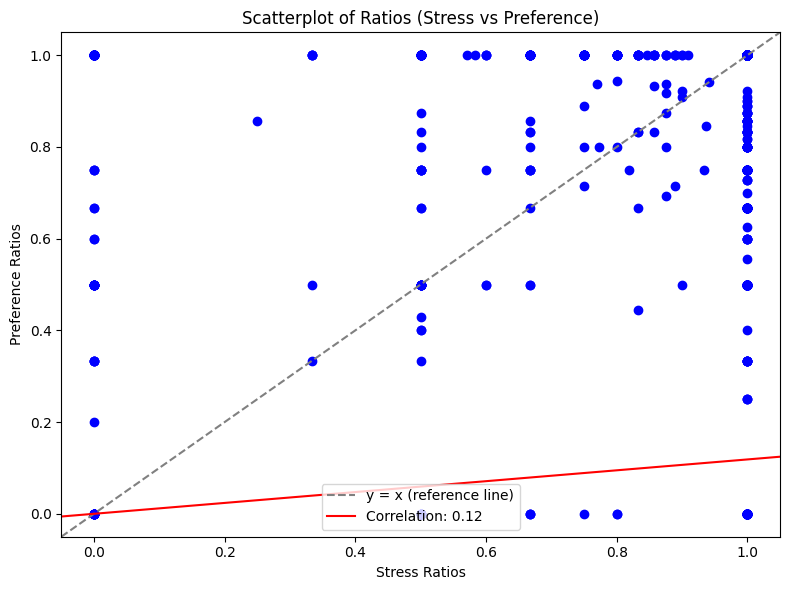

In [75]:
nt_all_df = pd.concat([nt_stress10_df, nt_stress25_df, nt_stress50_df])
tn_all_df = pd.concat([stress10_df, stress25_df, stress50_df])
ex_all_df = pd.concat([ex_stress10_df, ex_stress25_df, ex_stress50_df])
pref_all_df = pd.concat([preference10_df, preference25_df, preference50_df])


# Define the grid structure for the keys
g_values = [f"g{i}" for i in range(1, 6)]  # g1 to g5
l_values = [40, 45, 50, 55, 60, 65, 70, 75, 80]  # l40 to l80
ta_values = ["a", "b", "c"]  # a to c

# Generate all keys in the required format
keys = [f"{g}_l{l}_{ta}" for l in l_values for g in g_values for ta in ta_values]

# Generate all possible pairs (order-independent using combinations)
all_possible_pairs = list(combinations(keys, 2))

# Initialize the dictionary with all possible pairs as keys (frozensets for order-independence)
stress_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}
preference_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}


for index, row in nt_all_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        stress_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            stress_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 3:
            stress_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            stress_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            stress_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1

for index, row in pref_all_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        preference_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            preference_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 2:
            preference_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            preference_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            preference_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1


# Remove entries from where 'total' < 1
stress_pair_dict_10 = {k: v for k, v in stress_pair_dict_10.items() if v['total'] >= 1}
preference_pair_dict_10 = {k: v for k, v in preference_pair_dict_10.items() if v['total'] >= 1}


# # Find the intersection of keys from both dictionaries
common_keys = set(stress_pair_dict_10.keys()).intersection(preference_pair_dict_10.keys())

# # Create the filtered dictionaries with only the common keys
stress_pair_dict_10_filtered = {k: stress_pair_dict_10[k] for k in common_keys}
preference_pair_dict_10_filtered = {k: preference_pair_dict_10[k] for k in common_keys}

for key, value in stress_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Add 'ratio_lower_stress' to the filtered preference dictionary
for key, value in preference_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Ensure common_keys is a sequence by converting it to a list
# random_keys = random.sample(list(common_keys), 15)


# stress_pair_dict_10_filtered2 = {k: stress_pair_dict_10[k] for k in random_keys}
# preference_pair_dict_10_filtered2 = {k: preference_pair_dict_10[k] for k in random_keys}

keys_stress = [' & '.join(key) for key in stress_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_stress = [value['ratio_lower_stress'] for value in stress_pair_dict_10_filtered.values()]

keys_preference = [' & '.join(key) for key in preference_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_preference = [value['ratio_lower_stress'] for value in preference_pair_dict_10_filtered.values()]

correlation = np.corrcoef(ratios_stress, ratios_preference)[0, 1]

print(f"Correlation: {correlation}")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)  # Two rows, one column

# First bar chart
axes[0].bar(keys_stress, ratios_stress)
axes[0].set_title('Ratio Lower Stress (Stress Pairs)')
axes[0].set_ylabel('Ratio Lower Stress')
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Second bar chart
axes[1].bar(keys_preference, ratios_preference)
axes[1].set_title('Ratio Lower Stress (Preference Pairs)')
axes[1].set_xlabel('Pair')
axes[1].set_ylabel('Ratio Lower Stress')
axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Adjust layout
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ratios_stress, ratios_preference, color='blue')#, label=f'Correlation: {correlation:.2f}')
plt.title('Scatterplot of Ratios (Stress vs Preference)')
plt.xlabel('Stress Ratios')
plt.ylabel('Preference Ratios')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='y = x (reference line)')
plt.axline((0, 0), slope=correlation, color='red', linestyle='-', label=f'Correlation: {correlation:.2f}')
plt.legend()
plt.tight_layout()
plt.show()



# All graph size: trained vs preference

Correlation: 0.10818972651388416


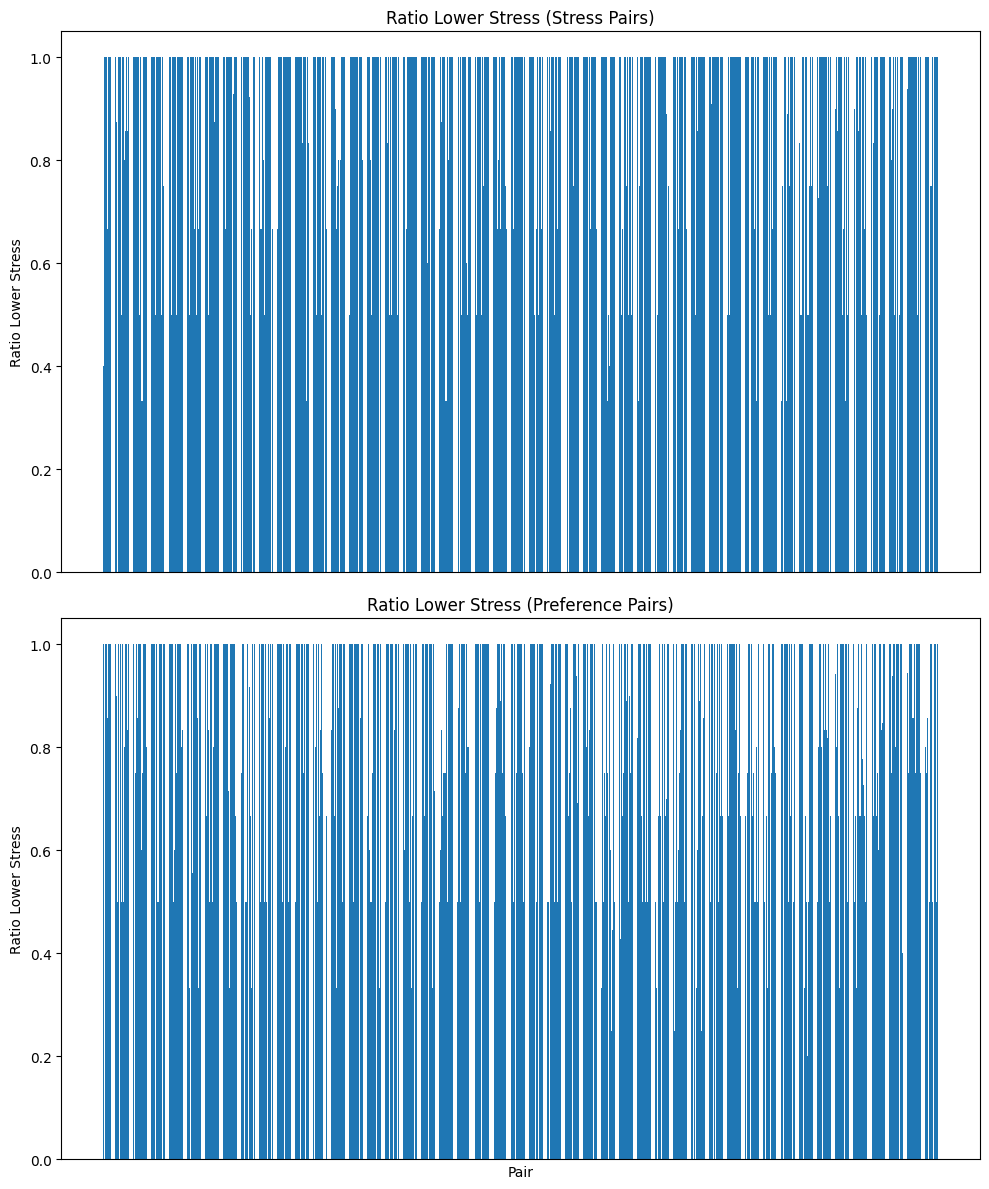

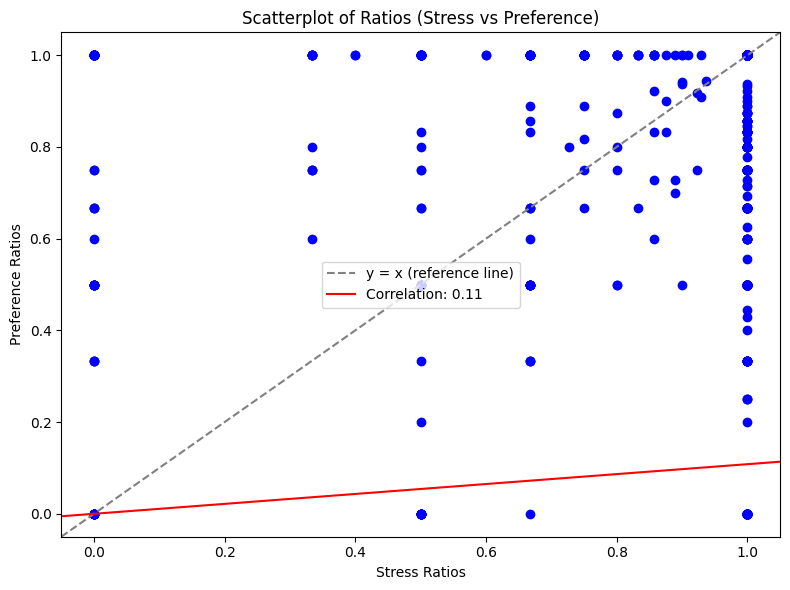

In [76]:
nt_all_df = pd.concat([nt_stress10_df, nt_stress25_df, nt_stress50_df])
tn_all_df = pd.concat([stress10_df, stress25_df, stress50_df])
ex_all_df = pd.concat([ex_stress10_df, ex_stress25_df, ex_stress50_df])
pref_all_df = pd.concat([preference10_df, preference25_df, preference50_df])


# Define the grid structure for the keys
g_values = [f"g{i}" for i in range(1, 6)]  # g1 to g5
l_values = [40, 45, 50, 55, 60, 65, 70, 75, 80]  # l40 to l80
ta_values = ["a", "b", "c"]  # a to c

# Generate all keys in the required format
keys = [f"{g}_l{l}_{ta}" for l in l_values for g in g_values for ta in ta_values]

# Generate all possible pairs (order-independent using combinations)
all_possible_pairs = list(combinations(keys, 2))

# Initialize the dictionary with all possible pairs as keys (frozensets for order-independence)
stress_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}
preference_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}


for index, row in tn_all_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        stress_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            stress_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 3:
            stress_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            stress_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            stress_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1

for index, row in pref_all_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        preference_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            preference_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 2:
            preference_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            preference_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            preference_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1


# Remove entries from where 'total' < 1
stress_pair_dict_10 = {k: v for k, v in stress_pair_dict_10.items() if v['total'] >= 1}
preference_pair_dict_10 = {k: v for k, v in preference_pair_dict_10.items() if v['total'] >= 1}


# # Find the intersection of keys from both dictionaries
common_keys = set(stress_pair_dict_10.keys()).intersection(preference_pair_dict_10.keys())

# # Create the filtered dictionaries with only the common keys
stress_pair_dict_10_filtered = {k: stress_pair_dict_10[k] for k in common_keys}
preference_pair_dict_10_filtered = {k: preference_pair_dict_10[k] for k in common_keys}

for key, value in stress_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Add 'ratio_lower_stress' to the filtered preference dictionary
for key, value in preference_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Ensure common_keys is a sequence by converting it to a list
# random_keys = random.sample(list(common_keys), 15)


# stress_pair_dict_10_filtered2 = {k: stress_pair_dict_10[k] for k in random_keys}
# preference_pair_dict_10_filtered2 = {k: preference_pair_dict_10[k] for k in random_keys}

keys_stress = [' & '.join(key) for key in stress_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_stress = [value['ratio_lower_stress'] for value in stress_pair_dict_10_filtered.values()]

keys_preference = [' & '.join(key) for key in preference_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_preference = [value['ratio_lower_stress'] for value in preference_pair_dict_10_filtered.values()]

correlation = np.corrcoef(ratios_stress, ratios_preference)[0, 1]

print(f"Correlation: {correlation}")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)  # Two rows, one column

# First bar chart
axes[0].bar(keys_stress, ratios_stress)
axes[0].set_title('Ratio Lower Stress (Stress Pairs)')
axes[0].set_ylabel('Ratio Lower Stress')
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Second bar chart
axes[1].bar(keys_preference, ratios_preference)
axes[1].set_title('Ratio Lower Stress (Preference Pairs)')
axes[1].set_xlabel('Pair')
axes[1].set_ylabel('Ratio Lower Stress')
axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Adjust layout
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ratios_stress, ratios_preference, color='blue')#, label=f'Correlation: {correlation:.2f}')
plt.title('Scatterplot of Ratios (Stress vs Preference)')
plt.xlabel('Stress Ratios')
plt.ylabel('Preference Ratios')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='y = x (reference line)')
plt.axline((0, 0), slope=correlation, color='red', linestyle='-', label=f'Correlation: {correlation:.2f}')
plt.legend()
plt.tight_layout()
plt.show()



# All graph size: expert vs preference

Correlation: 0.07797811338458391


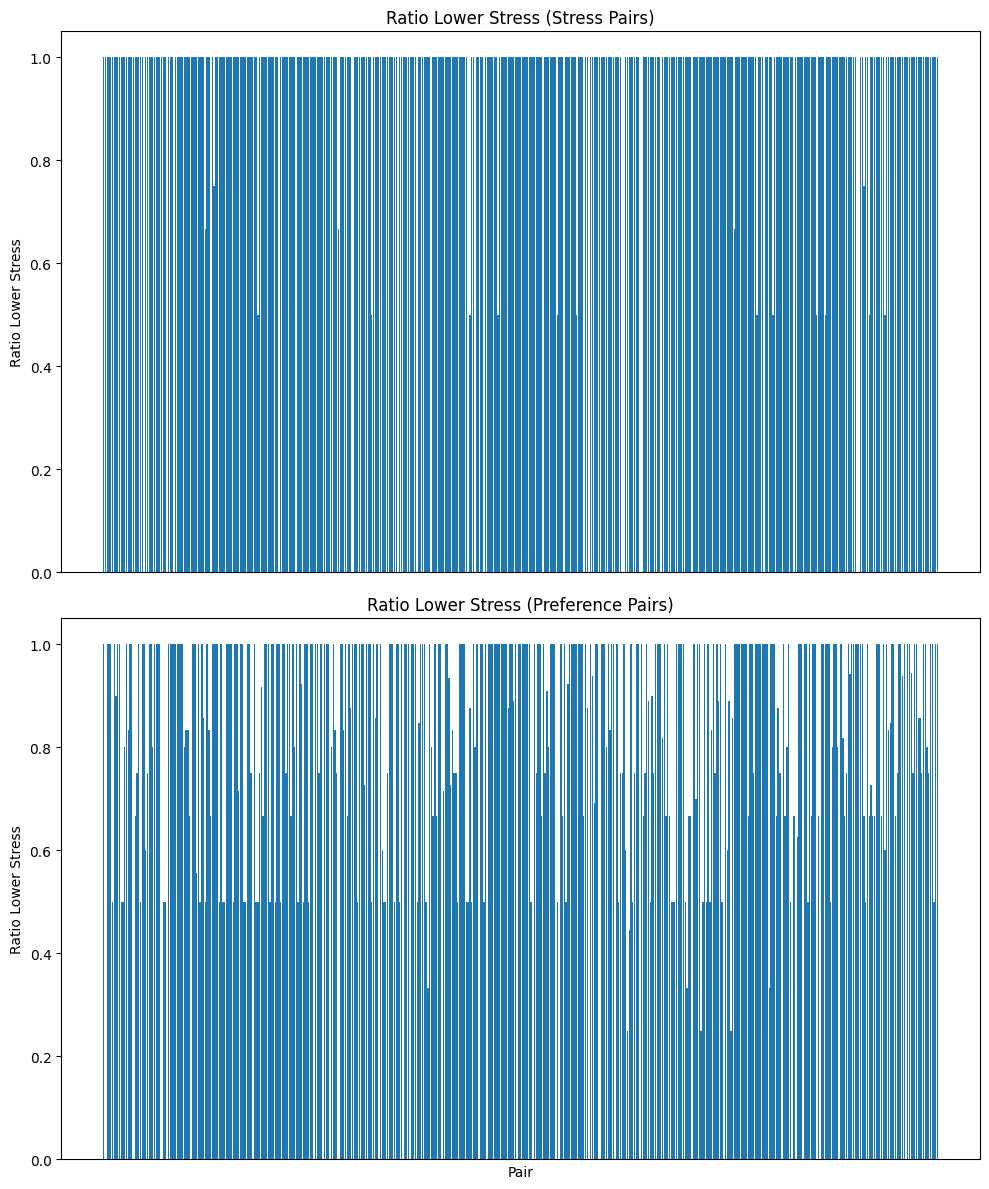

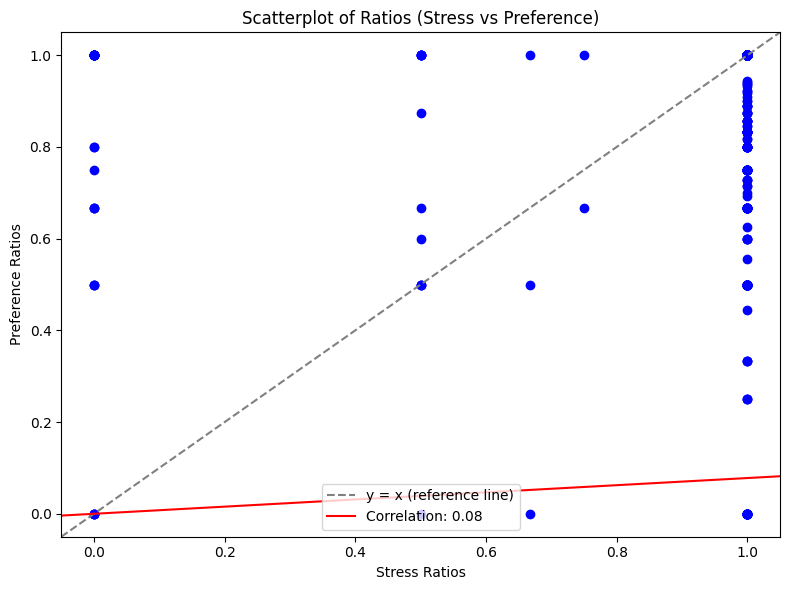

In [77]:
nt_all_df = pd.concat([nt_stress10_df, nt_stress25_df, nt_stress50_df])
tn_all_df = pd.concat([stress10_df, stress25_df, stress50_df])
ex_all_df = pd.concat([ex_stress10_df, ex_stress25_df, ex_stress50_df])
pref_all_df = pd.concat([preference10_df, preference25_df, preference50_df])


# Define the grid structure for the keys
g_values = [f"g{i}" for i in range(1, 6)]  # g1 to g5
l_values = [40, 45, 50, 55, 60, 65, 70, 75, 80]  # l40 to l80
ta_values = ["a", "b", "c"]  # a to c

# Generate all keys in the required format
keys = [f"{g}_l{l}_{ta}" for l in l_values for g in g_values for ta in ta_values]

# Generate all possible pairs (order-independent using combinations)
all_possible_pairs = list(combinations(keys, 2))

# Initialize the dictionary with all possible pairs as keys (frozensets for order-independence)
stress_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}
preference_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}


for index, row in ex_all_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        stress_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            stress_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 3:
            stress_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            stress_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            stress_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1

for index, row in pref_all_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        preference_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            preference_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 2:
            preference_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            preference_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            preference_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1


# Remove entries from where 'total' < 1
stress_pair_dict_10 = {k: v for k, v in stress_pair_dict_10.items() if v['total'] >= 1}
preference_pair_dict_10 = {k: v for k, v in preference_pair_dict_10.items() if v['total'] >= 1}


# # Find the intersection of keys from both dictionaries
common_keys = set(stress_pair_dict_10.keys()).intersection(preference_pair_dict_10.keys())

# # Create the filtered dictionaries with only the common keys
stress_pair_dict_10_filtered = {k: stress_pair_dict_10[k] for k in common_keys}
preference_pair_dict_10_filtered = {k: preference_pair_dict_10[k] for k in common_keys}

for key, value in stress_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Add 'ratio_lower_stress' to the filtered preference dictionary
for key, value in preference_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Ensure common_keys is a sequence by converting it to a list
# random_keys = random.sample(list(common_keys), 15)


# stress_pair_dict_10_filtered2 = {k: stress_pair_dict_10[k] for k in random_keys}
# preference_pair_dict_10_filtered2 = {k: preference_pair_dict_10[k] for k in random_keys}

keys_stress = [' & '.join(key) for key in stress_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_stress = [value['ratio_lower_stress'] for value in stress_pair_dict_10_filtered.values()]

keys_preference = [' & '.join(key) for key in preference_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_preference = [value['ratio_lower_stress'] for value in preference_pair_dict_10_filtered.values()]

correlation = np.corrcoef(ratios_stress, ratios_preference)[0, 1]

print(f"Correlation: {correlation}")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)  # Two rows, one column

# First bar chart
axes[0].bar(keys_stress, ratios_stress)
axes[0].set_title('Ratio Lower Stress (Stress Pairs)')
axes[0].set_ylabel('Ratio Lower Stress')
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Second bar chart
axes[1].bar(keys_preference, ratios_preference)
axes[1].set_title('Ratio Lower Stress (Preference Pairs)')
axes[1].set_xlabel('Pair')
axes[1].set_ylabel('Ratio Lower Stress')
axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Adjust layout
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ratios_stress, ratios_preference, color='blue')#, label=f'Correlation: {correlation:.2f}')
plt.title('Scatterplot of Ratios (Stress vs Preference)')
plt.xlabel('Stress Ratios')
plt.ylabel('Preference Ratios')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='y = x (reference line)')
plt.axline((0, 0), slope=correlation, color='red', linestyle='-', label=f'Correlation: {correlation:.2f}')
plt.legend()
plt.tight_layout()
plt.show()



# All graph sizes, all GD participants vs preference

Correlation: 0.15824030188540097


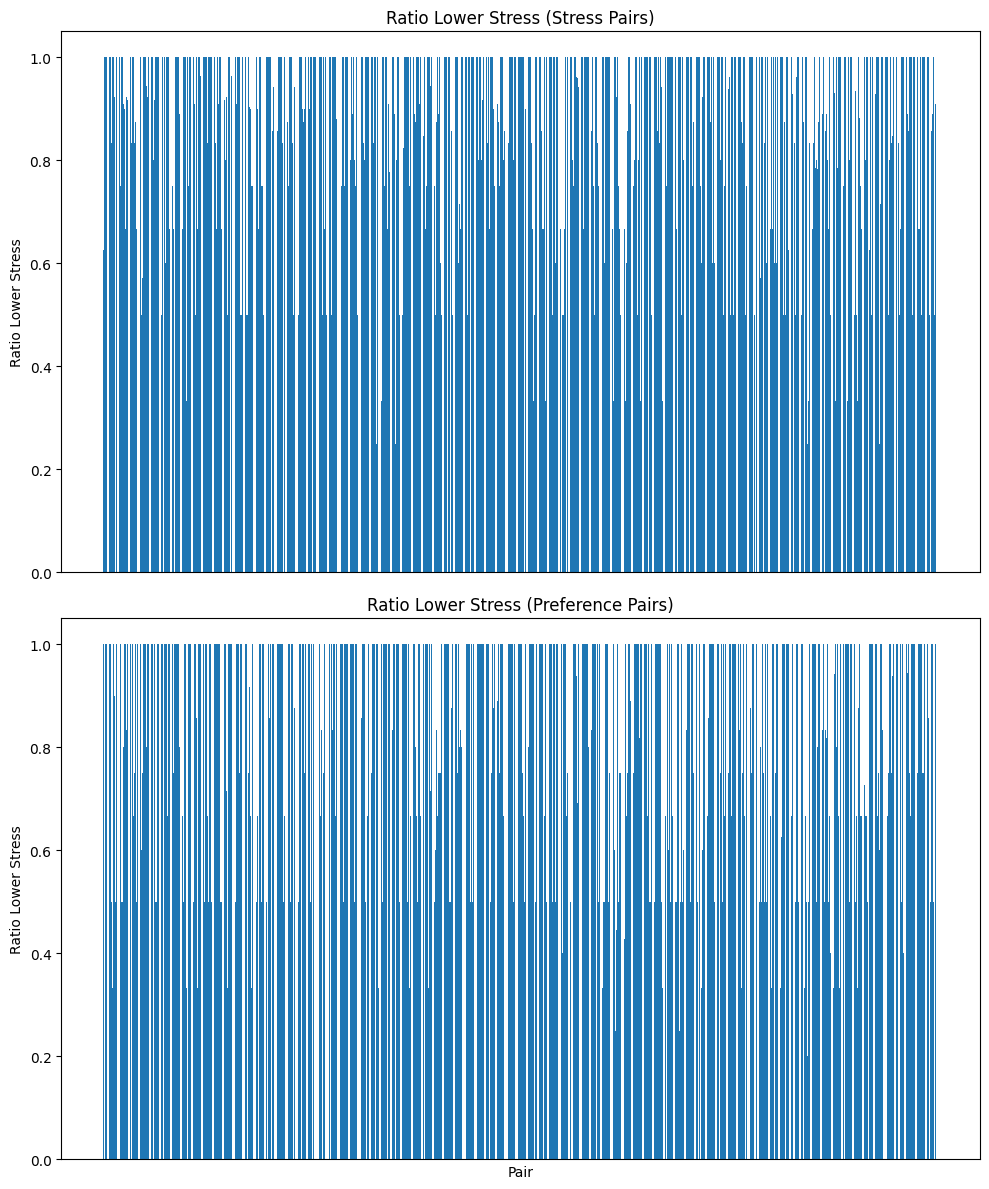

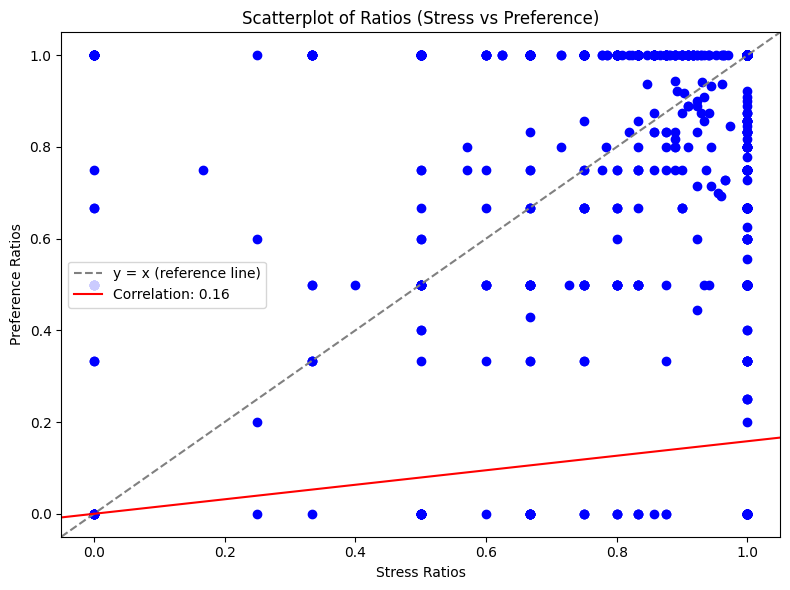

In [79]:
nt_all_df = pd.concat([nt_stress10_df, nt_stress25_df, nt_stress50_df])
tn_all_df = pd.concat([stress10_df, stress25_df, stress50_df])
ex_all_df = pd.concat([ex_stress10_df, ex_stress25_df, ex_stress50_df])
gd_all_df = pd.concat([nt_all_df, tn_all_df, ex_all_df])
pref_all_df = pd.concat([preference10_df, preference25_df, preference50_df])


# Define the grid structure for the keys
g_values = [f"g{i}" for i in range(1, 6)]  # g1 to g5
l_values = [40, 45, 50, 55, 60, 65, 70, 75, 80]  # l40 to l80
ta_values = ["a", "b", "c"]  # a to c

# Generate all keys in the required format
keys = [f"{g}_l{l}_{ta}" for l in l_values for g in g_values for ta in ta_values]

# Generate all possible pairs (order-independent using combinations)
all_possible_pairs = list(combinations(keys, 2))

# Initialize the dictionary with all possible pairs as keys (frozensets for order-independence)
stress_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}
preference_pair_dict_10 = {frozenset(pair): {pair[0]: 0, pair[1]: 0, 'total': 0, 'times_lower_stress_chosen': 0} for pair in all_possible_pairs}


for index, row in gd_all_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        stress_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            stress_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 3:
            stress_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            stress_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            stress_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1

for index, row in pref_all_df.iterrows():
    drawings = eval(row['drawings'])  # Convert string to list of pairs

    for (i, pair), delta, accuracy in zip(enumerate(drawings), row['deltas'], row['accuracy']):
        if delta == 0:
            continue
        # Update the 'total' for the pair
        pair_set = frozenset(pair)
        preference_pair_dict_10[pair_set]['total'] += 1

        # Update the 'times_chosen' for the selected drawing
        if row['answers'][i] == 1:
            preference_pair_dict_10[pair_set][pair[0]] += 1  # First drawing selected
        elif row['answers'][i] == 2:
            preference_pair_dict_10[pair_set][pair[1]] += 1  # Second drawing selected
        else:
            preference_pair_dict_10[pair_set]['total'] -= 1

        if accuracy == 1:
            preference_pair_dict_10[pair_set]['times_lower_stress_chosen'] += 1


# Remove entries from where 'total' < 1
stress_pair_dict_10 = {k: v for k, v in stress_pair_dict_10.items() if v['total'] >= 1}
preference_pair_dict_10 = {k: v for k, v in preference_pair_dict_10.items() if v['total'] >= 1}


# # Find the intersection of keys from both dictionaries
common_keys = set(stress_pair_dict_10.keys()).intersection(preference_pair_dict_10.keys())

# # Create the filtered dictionaries with only the common keys
stress_pair_dict_10_filtered = {k: stress_pair_dict_10[k] for k in common_keys}
preference_pair_dict_10_filtered = {k: preference_pair_dict_10[k] for k in common_keys}

for key, value in stress_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Add 'ratio_lower_stress' to the filtered preference dictionary
for key, value in preference_pair_dict_10_filtered.items():
    value['ratio_lower_stress'] = value['times_lower_stress_chosen'] / value['total']


# Ensure common_keys is a sequence by converting it to a list
# random_keys = random.sample(list(common_keys), 15)


# stress_pair_dict_10_filtered2 = {k: stress_pair_dict_10[k] for k in random_keys}
# preference_pair_dict_10_filtered2 = {k: preference_pair_dict_10[k] for k in random_keys}

keys_stress = [' & '.join(key) for key in stress_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_stress = [value['ratio_lower_stress'] for value in stress_pair_dict_10_filtered.values()]

keys_preference = [' & '.join(key) for key in preference_pair_dict_10_filtered.keys()]  # Combine frozenset items into a string for labeling
ratios_preference = [value['ratio_lower_stress'] for value in preference_pair_dict_10_filtered.values()]

correlation = np.corrcoef(ratios_stress, ratios_preference)[0, 1]

print(f"Correlation: {correlation}")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)  # Two rows, one column

# First bar chart
axes[0].bar(keys_stress, ratios_stress)
axes[0].set_title('Ratio Lower Stress (Stress Pairs)')
axes[0].set_ylabel('Ratio Lower Stress')
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Second bar chart
axes[1].bar(keys_preference, ratios_preference)
axes[1].set_title('Ratio Lower Stress (Preference Pairs)')
axes[1].set_xlabel('Pair')
axes[1].set_ylabel('Ratio Lower Stress')
axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-ticks

# Adjust layout
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ratios_stress, ratios_preference, color='blue')#, label=f'Correlation: {correlation:.2f}')
plt.title('Scatterplot of Ratios (Stress vs Preference)')
plt.xlabel('Stress Ratios')
plt.ylabel('Preference Ratios')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='y = x (reference line)')
plt.axline((0, 0), slope=correlation, color='red', linestyle='-', label=f'Correlation: {correlation:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

